In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
from venn import venn
import itertools

In [2]:
## if you want to color plot by chromosome
chrZ = ['CM051124', 'JAQHUL010000048', 'JAQHUL010000053', 'JAQHUL010000095', 'JAQHUL010000123', 
        'JAQHUL010000125', 'JAQHUL010000393', 'JAQHUL010000438', 'JAQHUL010000478', 'JAQHUL010000912', 
        'JAQHUL010001315', 'JAQHUL010001454', 'MU790496', 'MU790497']

chrW = ['CM051123', 'JAQHUL010000090', 'JAQHUL010000098', 'JAQHUL010000119', 'JAQHUL010000132', 
        'JAQHUL010000162', 'JAQHUL010000235', 'JAQHUL010000251', 'JAQHUL010000366', 'JAQHUL010000503', 
        'JAQHUL010000510', 'JAQHUL010000624', 'JAQHUL010001019', 'JAQHUL010001216', 'JAQHUL010001238',
        'JAQHUL010001337', 'MU790483', 'MU790484', 'MU790485', 'MU790487', 'MU790490']

wnt_genes = ['ANKRD6', 'BCL9L', 'CPE', 'DAB2', 'DCDC2', 'EDN1', 'EGF', 'FGF2', 'FOXO1', 'FZD1', 'FZD5', 
             'GLI3', 'GPC5', 'GPC6', 'GRK5', 'GSC', 'HECW1', 'HHEX', 'INVS', 'KREMEN1', 'MDFIC', 'OTULIN', 
             'PPP2CA', 'PRKN', 'RBPJ', 'RECK', 'ROR2', 'SHISA2', 'SOX7', 'SULF2', 'TMEM131L', 'TMEM67', 
             'TSKU', 'TTC21B', 'UBR5', 'WIF1', 'WNK2', 'WNT5A', 'WNT5B']
neuro_genes = ['BTBD9', 'ITSN2', 'SYN3', 'SLC18A2', 'NLGN3', 'OPHN1']

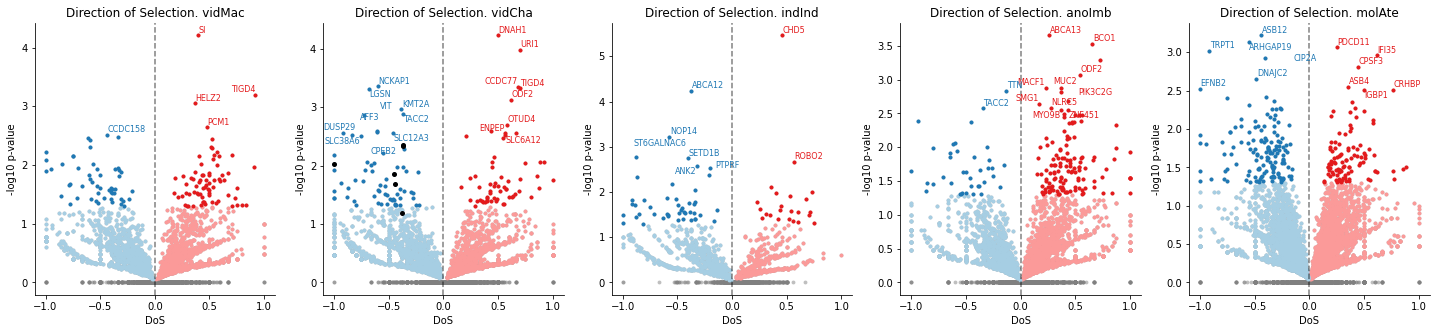

In [4]:
### Plot DoS from MK test for all 3 clades
dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb', 'molAte']
selected_genes = []

fig, axes = plt.subplots(2, 3, figsize=(3*5, 2*5))
p = sns.color_palette('Paired')

all_DFs = {}
i = 0
for db in dbs:
    j = i // 3
    k = i % 3
    axi = axes[i]
    
    ## Load the data by gene
    dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
    file_name = 'MK_test_{}_ncbi/gene.longest.mk.tsv'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df = df.dropna()
    df['dos'] = pd.to_numeric(df['dos'])
    all_DFs[db] = df    
                              
    ## p-value cutoff
    pval_cutoff_lax = -np.log10(1)
    pval_cutoff_strict = -np.log10(0.05)
    
    ## Adjust NI
    min_odds = df[df['mk.odds.ni'] != 0]['mk.odds.ni'].min()
    max_odds = df[df['mk.odds.ni'] != float('inf')]['mk.odds.ni'].max()
    df['corr.ni'] = [min_odds/4 if i==0 else max_odds*4 if i==float('inf') else i for i in df['mk.odds.ni']]
    df['log.pval'] = -np.log10(df['mk.raw.p.value'])
    df['log.ni'] = -np.log10(df['corr.ni'])
    
    ## Make sets according to the p-value
    df_Dpos_strict = df[(pd.to_numeric(df['dos']) > 0) & (df['log.pval'] > pval_cutoff_strict)]
    df_Dneg_strict = df[(pd.to_numeric(df['dos']) < 0) & (df['log.pval'] > pval_cutoff_strict)]
    df_Dpos_lax = df[(pd.to_numeric(df['dos']) > 0) & (df['log.pval'] > pval_cutoff_lax)]
    df_Dneg_lax = df[(pd.to_numeric(df['dos']) < 0) & (df['log.pval'] > pval_cutoff_lax)]
    df_wnt = df[df['gene'].isin(wnt_genes)]
    df_neuro = df[df['gene'].isin(neuro_genes)]
    
    ## Plot DoS
    sns.scatterplot(ax=axi, data=df, x='dos', y='log.pval', alpha=0.5, linewidth=0, s=15, color='grey')
    sns.scatterplot(ax=axi, data=df_Dpos_lax, x='dos', y='log.pval', linewidth=0, s=15, color=p[4])
    sns.scatterplot(ax=axi, data=df_Dneg_lax, x='dos', y='log.pval', linewidth=0, s=15, color=p[0])
    sns.scatterplot(ax=axi, data=df_Dpos_strict, x='dos', y='log.pval', linewidth=0, s=15, color=p[5])
    sns.scatterplot(ax=axi, data=df_Dneg_strict, x='dos', y='log.pval', linewidth=0, s=15, color=p[1])
    if db == 'vidCha':
        sns.scatterplot(ax=axi, data=df_neuro, x='dos', y='log.pval', linewidth=0, s=25, color='k')
    
    
    axi.set_title('Direction of Selection. {}'.format(db))
    axi.set(xlabel='DoS', ylabel='-log10 p-value')
#     axi.axhline(pval_cutoff, color='k', alpha=0.5, ls='--')
    axi.axvline(0, color='k', alpha=0.5, ls='--')
    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
    i += 1
    
    labels = []
    for x, y, g in zip(df_Dpos_strict['dos'], df_Dpos_strict['log.pval'], df_Dpos_strict['gene']):
        if ((y > 2.5) and (not g.startswith('reg_')) and (not g.startswith('LOC'))):
            labels.append(axi.text(x=x, y=y, s=g, color=p[5], size=8))
    adjust_text(labels, ax=axi)
    
    labels = []
    for x, y, g in zip(df_Dneg_strict['dos'], df_Dneg_strict['log.pval'], df_Dneg_strict['gene']):
        if ((y > 2.5) and (not g.startswith('reg_')) and (not g.startswith('LOC'))):
            labels.append(axi.text(x=x, y=y, s=g, color=p[1], size=8))
    adjust_text(labels, ax=axi)
    
# pdf_name = 'dos.pval_volcanos.mk_test.4_db.pdf'
pdf_name = 'dos.pval_volcanos.mk_test.5_db.pdf'

# fig.savefig(pdf_name, bbox_inches='tight')

In [7]:
for i in range(6):
    j = i // 3
    k = i % 3
    print(j, k)

0 0
0 1
0 2
1 0
1 1
1 2


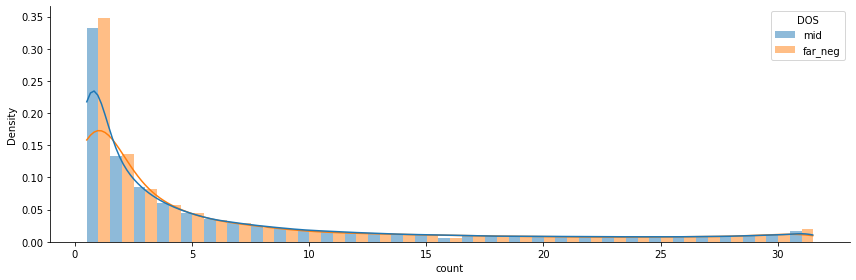

In [61]:
## Check TajimaD and AF distributions for DoS < 0 and DoS > 0
db = 'indInd'

file_name_D = 'PopGen_{}/all_dos.passed.{}.10k.Tajima.D'.format(db, db)
file_data_D = glob(dir_path + file_name_D)[0]
df_D = pd.read_csv(file_data_D, sep='\t')
df_D = df_D.dropna()

file_name = 'MK_test_{}_ncbi/AF.by_category.tsv'.format(db)
file_data = glob(dir_path + file_name)[0]
af_df = pd.read_csv(file_data, sep='\t')
af_df['count'] = af_df['AF'] * 32

fig, axes = plt.subplots(figsize=(12, 4))
sns.histplot(df_D[df_D['DOS'] != 'ra_na'], x='TajimaD', hue='DOS', alpha=0.3,
             linewidth=0, stat="density", kde=True, common_norm=False)

# sets = ['far_neg', 'mid']
# sns.histplot(af_df[af_df['DOS'].isin(sets)], x='count', hue='DOS', binwidth=1, alpha=0.5,
#              linewidth=0, stat="density", multiple="dodge", kde=True, common_norm=False)


sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [164]:
## Get genes and their AF by category
# requires all_DBs!
dbs = ['vidMac', 'vidCha', 'indInd']

## store genes by GO category in a dictionary
goterms_dict = {}
for db in dbs:
    af_files = glob(dir_path + 'MK_test_{}_ncbi/*genes.{}.lst'.format(db, db))
    for af_file in af_files:
        i = af_file.split('/')[-1].split('.')[0]
        with open(af_file, 'r') as inf:
            genes = inf.read().rstrip().split('\n')
            goterms_dict[(db, i)] = genes

## Make nonsyn AF dataframe
all_AFs = {'db': [],
           'genes': [],
           'AF': []
          }

for db_term in goterms_dict:
    db = db_term[0]
    term = db_term[1]
    
    # get corresponding nonsynonymous AFs from all_DFs
    dfi = all_DFs[db]
    af_i = ''.join(list(dfi[dfi['gene'].isin(goterms_dict[(db, term)])]['af_syn'])).split(',')
    all_genes_af_i = ''.join(list(dfi['af_syn'])).split(',')
    
    # drop empty elements
    af_i = ' '.join(af_i).split()
    all_genes_af_i = ' '.join(all_genes_af_i).split()

    # First, add AFs of all genes if they are not there yet
    if db not in all_AFs['db']:
        all_AFs['db'].extend([db] * len(all_genes_af_i))
        all_AFs['genes'].extend(['all_genes'] * len(all_genes_af_i))
        all_AFs['AF'].extend([float(af) for af in all_genes_af_i])
    
    # Next, add this category
    all_AFs['db'].extend([db] * len(af_i))
    all_AFs['genes'].extend([term] * len(af_i))
    all_AFs['AF'].extend([float(af) for af in af_i])
    
all_AFs = pd.DataFrame(all_AFs)



In [165]:
## Define colors
red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

p = [blue, red, green, purple]

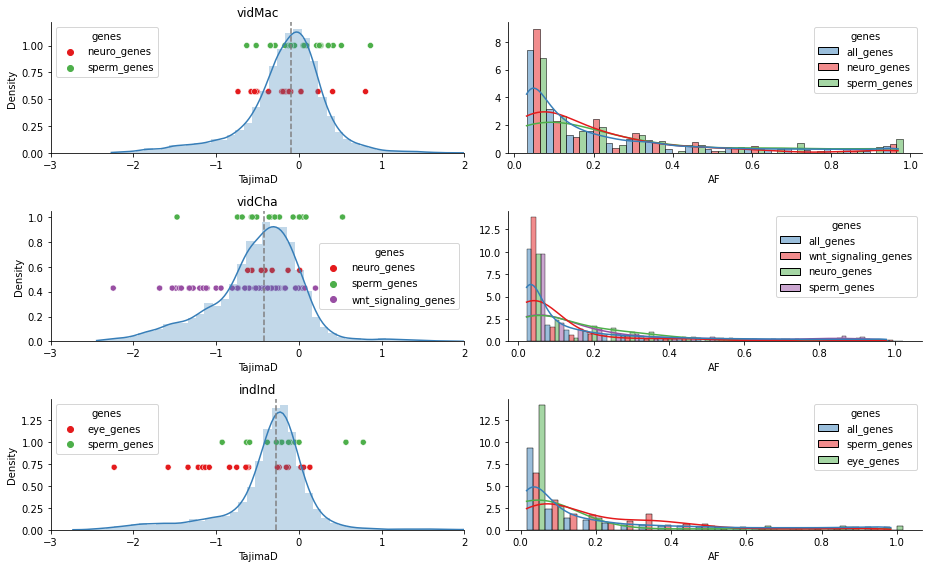

In [166]:
## Check TajimaD and AF distributions for DoS < 0 and DoS > 0
# requires all_AFs dataframe!
dbs = ['vidMac', 'vidCha', 'indInd']
exclude = ['retina_genes', 'cardio_genes']

## TajimaD
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name_D = 'all_genes.by_term.by_db.TajimaD'
file_data_D = glob(dir_path + file_name_D)[0]
d_df = pd.read_csv(file_data_D, sep='\t')

## AF
file_name = 'all_genes.by_term.by_db.AF'
file_data = glob(dir_path + file_name)[0]
af_df = pd.read_csv(file_data, sep='\t')


terms = list(set(d_df['genes']))
term_dict = {}
for i in range(len(terms)):
    term_dict[terms[i]] = (i + 1) / len(terms)
d_df['y'] = [term_dict[g] for g in d_df['genes']]


fig, axes = plt.subplots(3, 2, figsize=(13, 8))


i = 0
for db in dbs:
    ## Plot TajimaD
    axi = axes[i][0]
    dfi = d_df[(d_df['db'] == db) & (~d_df['genes'].isin(exclude))]
    sns.histplot(ax=axi, data=dfi[dfi['genes'] == 'all_genes'],
                 x='TajimaD',
                 binwidth=0.1,
                 color=blue,
                 alpha=0.3,
                 linewidth=0,
                 stat="density",
                 kde=True,
                 common_norm=False)

    sns.scatterplot(ax=axi, data=dfi[dfi['genes'] != 'all_genes'],
                    x='TajimaD', y='y', hue='genes', palette=p[1: len(set(dfi['genes']))])
    axi.set(xlim=(-3, 2))
    axi.set_title(db)
    axi.axvline(x=dfi[dfi['genes'] == 'all_genes']['TajimaD'].median(), c='grey', ls='--', lw=1.5)
    
    ## Plot AF bt GO category
    axi = axes[i][1]

    dfi = all_AFs[(all_AFs['db'] == db) & (~all_AFs['genes'].isin(exclude))]
    sns.histplot(ax=axi, data=dfi, 
                 x='AF', 
                 binwidth=.05,
                 hue='genes',
                 palette=p[: len(set(dfi['genes']))],
                 alpha=0.5,
                 stat="density",
                 multiple="dodge",
                 kde=True,
                 common_norm=False)
    axi.set_ylabel('')
    i += 1
    

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'AFsyn_and_TajimaD.genes_by_category.all_db.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

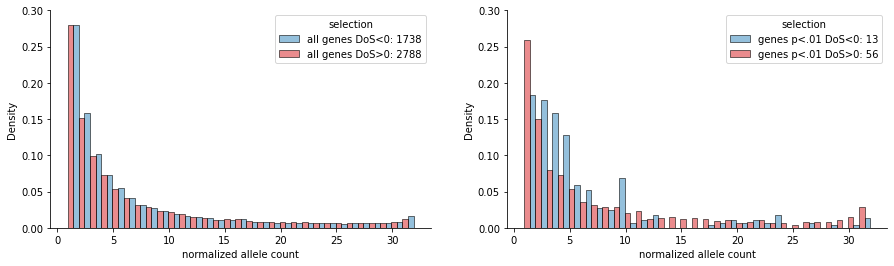

In [129]:
## Allele frequency spectra
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites/MK_test/'
file_name = 'AF.by_category.tsv'
file_data = glob(dir_path + file_name)[0]
af_df = pd.read_csv(file_data, sep='\t')
af_df['count'] = af_df['AF'] * 32

af_df_strong = af_df[af_df['selection'].isin(['strong_positive', 'strong_negative'])]
af_df_rand = af_df[af_df['selection'].isin(['rand_positive', 'rand_negative', 'all_positive', 'all_negative'])]

## plot
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
ax1, ax2 = axes[0], axes[1]
sns.set_palette(['#d7191c', '#2b83ba'])


sns.histplot(ax=ax1, data=af_df_rand, x='count', hue='selection', binwidth=1, 
             stat='density', common_norm=False, multiple="dodge", alpha=0.5)
sns.histplot(ax=ax2, data=af_df_strong, x='count', hue='selection', binwidth=1, 
             stat='density', common_norm=False, multiple="dodge", alpha=0.5)

ax1.set(xlabel='normalized allele count')
ax2.set(xlabel='normalized allele count')
ax1.legend(title='selection', loc='upper right', labels=['all genes DoS<0: 1738', 'all genes DoS>0: 2788'])
ax2.legend(title='selection', loc='upper right', labels=['genes p<.01 DoS<0: 13', 'genes p<.01 DoS>0: 56'])
ax1.set(ylim=(0, 0.3))
ax2.set(ylim=(0, 0.3))
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

pdf_name = 'spectra_AF_all_and_strong.pdf'

# fig.savefig(pdf_name, bbox_inches='tight')

all nonsyn variants DoS>0 vs DoS<0, p-value: 1.0
strong nonsyn variants DoS>0 vs DoS<0, p-value: 1.9303894371880403e-07


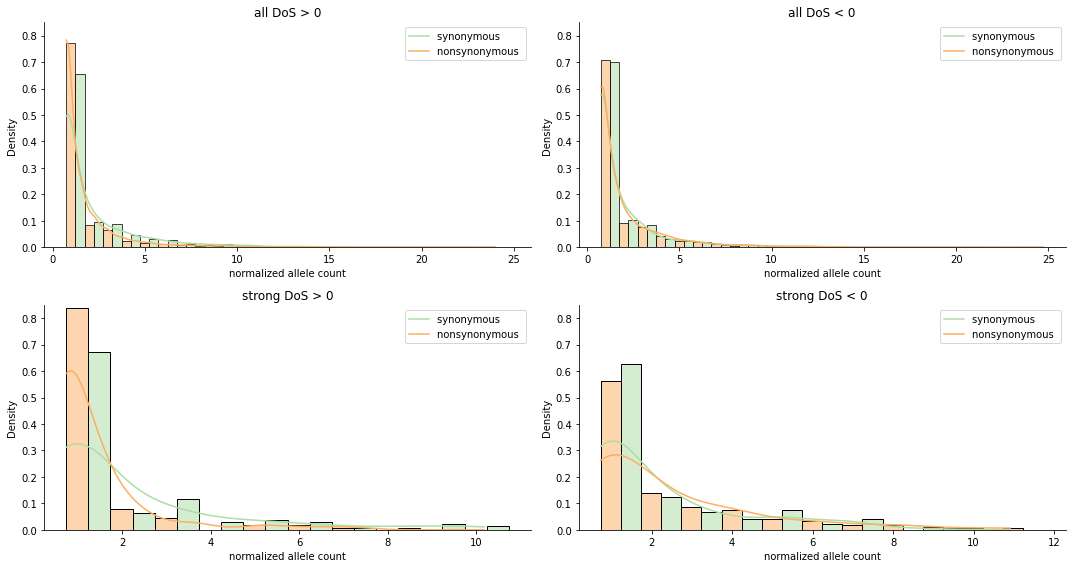

In [81]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# file_name = 'strict_filt.AF.by_category.snpEff.tsv'
# file_name = 'MK_test_vidMac_group/snpEff/AF.by_category.snpEff.tsv'
file_name = 'MK_test_vidCha_group/snpEff/AF.by_category.snpEff.tsv'

file_data = glob(dir_path + file_name)[0]
af_df = pd.read_csv(file_data, sep='\t')
af_df['count'] = af_df['AF'] * 32

data_all_pos = af_df[af_df['selection_conservative'] == 'all_positive']
data_all_neg = af_df[af_df['selection_conservative'] == 'all_negative']
data_strong_pos = af_df[af_df['selection_conservative'] == 'strong_positive']
data_strong_neg = af_df[af_df['selection_conservative'] == 'strong_negative']
# af_df_strong = af_df[af_df['selection'].isin(['strong_positive', 'strong_negative'])]
af_df_rand = af_df[af_df['selection'].isin(['rand_positive', 'rand_negative', 'all_positive', 'all_negative'])]

## plot
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
sns.set_palette(['#fdae61', '#abdda4'])

## all genes
sns.histplot(ax=ax1, data=data_all_pos, x='count', 
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

sns.histplot(ax=ax2, data=data_all_neg, x='count',
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

## strong genes
sns.histplot(ax=ax3, data=data_strong_pos, x='count', 
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

sns.histplot(ax=ax4, data=data_strong_neg, x='count',
             hue='impact', binwidth=1, stat='density', common_norm=False, multiple="dodge", kde=True)

ax1.set_title('all DoS > 0')
ax2.set_title('all DoS < 0')
ax3.set_title('strong DoS > 0')
ax4.set_title('strong DoS < 0')

for axi in [ax1, ax2, ax3, ax4]:
    axi.legend(title='', loc='upper right', labels=['synonymous ', 'nonsynonymous '])
    axi.set(xlabel='normalized allele count')
    axi.set(ylim=(0, 0.85))

fig.tight_layout()  
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

pdf_name = 'spectra_AF_sym_nonsym.all_and_strong.pos_and_neg.pdf'

# fig.savefig(pdf_name, bbox_inches='tight')


### Compare distributions
print('all nonsyn variants DoS>0 vs DoS<0, p-value: {}'.format(stats.ks_2samp(data_all_pos[data_all_pos['impact'] == 'missense_variant']['AF'], 
               data_all_neg[data_all_neg['impact'] == 'missense_variant']['AF'], 
               alternative='two-sided')[1]))
print('strong nonsyn variants DoS>0 vs DoS<0, p-value: {}'.format(stats.ks_2samp(data_strong_pos[data_strong_pos['impact'] == 'missense_variant']['AF'], 
               data_strong_neg[data_strong_neg['impact'] == 'missense_variant']['AF'], 
               alternative='two-sided')[1]))

In [32]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# dbs = ['vidMac', 'vidCha']
dbs = ['indInd', 'indInd_ground', 'indInd_tree']
# file_names = ['MK_test_vidMac_group/gene.longest.mk.tsv', 'MK_test_vidCha_group/gene.longest.mk.tsv']
dir_names = ['MK_test_indInd_group', 'MK_test_indInd_ground', 'MK_test_indInd_tree']

D = {}
for i in range(len(dbs)):
    db = dbs[i]
    file_name = '{}/gene.longest.mk.tsv'.format(dir_names[i])
    file_data = glob(dir_path + file_name)[0]
    d = pd.read_csv(file_data, sep='\t')
    d = d.dropna()
    D[db] = d
    i += 1

In [33]:
def get_genes_dos_pval(d, dos, pval):
    ## returns list of genes from dataframe according to requested thresholds
    
    if dos == 'pos':
        return set(d[(d['dos'] > 0) & (d['mk.raw.p.value'] < pval)]['gene'])
    if dos == 'neg':
        return set(d[(d['dos'] < 0) & (d['mk.raw.p.value'] < pval)]['gene'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


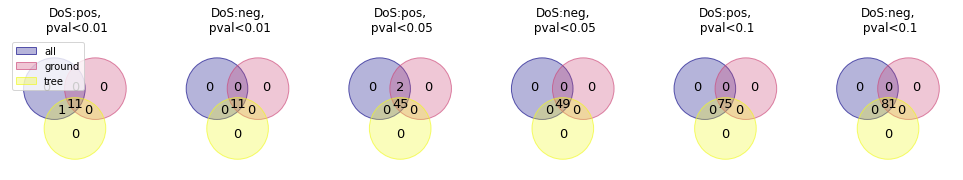

In [44]:
## Calculate overlap between dbs
# d1 = D['vidMac']
# d2 = D['vidCha']
d1 = D['indInd']
d2 = D['indInd_ground']
d3 = D['indInd_tree']
# db_sets = [ 'vidMac_str_pos', 'vidMac_str_neg', 'vidMac_pos', 'vidMac_neg',
#             'vidCha_str_pos', 'vidCha_str_neg', 'vidCha_pos', 'vidCha_neg']


fig, axes = plt.subplots(1, 6, figsize=(17, 12))


x = [('pos', .01), ('neg', .01), ('pos', .05), ('neg', .05), ('pos', .1), ('neg', .1)]
# x = [('pos', .01), ('neg', .01), ('pos', .05), ('neg', .05)]

for i in range(len(x)):
    db_set = x[i]
    dos = db_set[0]
    pval = db_set[1]
    all_db_sets = {}
    set_info1 = 'indInd_{}_{}'.format(dos, pval)
    set_info2 = 'indInd_ground_{}_{}'.format(dos, pval)
    set_info3 = 'indInd_tree_{}_{}'.format(dos, pval)
    all_db_sets[set_info1] = get_genes_dos_pval(d1, dos, pval)
    all_db_sets[set_info2] = get_genes_dos_pval(d2, dos, pval)
    all_db_sets[set_info3] = get_genes_dos_pval(d3, dos, pval)
#     print(all_db_sets[set_info1] & all_db_sets[set_info2]) 
    
    axi = axes[i]
    venn(all_db_sets, cmap='plasma', alpha=0.3, ax=axi)
    axi.set_title('DoS:{},\n pval<{}'.format(dos, pval))
    if i != 0:
        axi.legend(frameon=False)
    else:
        axi.legend(loc='upper left', labels=['all', 'ground', 'tree'])
        
# pdf_name = 'venns.DoS_pval.vidMac_vidCha.pdf'
pdf_name = 'venns.DoS_pval.indInd_all_ground_tree.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [4]:
def make_position(dfi, col_chr, col_start):
    ## sorts by chromosome number and adds absolute postion column
    
    dfi = dfi.dropna()
    exclude = ['chrZ', 'chrW', 'chrNA', 'chrMT']
    dfi['COUNT'] = dfi[col_chr].str.replace('chr', '')
    
    dfi_num = dfi[ ~dfi[col_chr].isin(exclude)]
    dfi_Z = dfi[dfi[col_chr] == 'chrZ']
    dfi_W = dfi[dfi[col_chr] == 'chrW']
    
    dfi_num['COUNT'] = pd.to_numeric(dfi_num['COUNT'])
    dfi_num = dfi_num.sort_values(by=['COUNT', col_start])
    
    dfi_merged = pd.concat([dfi_num, dfi_Z, dfi_W], ignore_index=True)
    dfi_merged['POSITION'] = [x / 1000 for x in range(dfi_merged.shape[0])]
    return dfi_merged

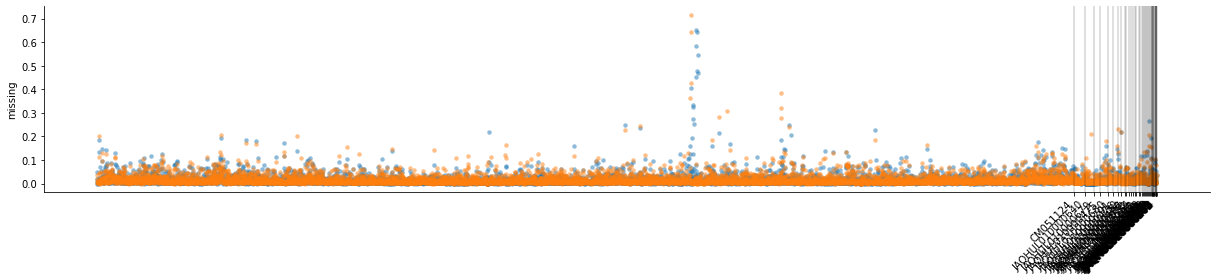

In [39]:
## How much is missing in sex chromosomes per window in tree VS ground honeyguides?
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'PopGen_indInd/window_100.chrZ_chrW.tree_ground.missingness.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['chr'] == 'chrZ']

fig, axes = plt.subplots(figsize=(17, 4*1))
# ax1, ax2 = axes[0], axes[1]
p = sns.color_palette("tab10")

df_tree = df[df['group'] == 'tree']
df_ground = df[df['group'] == 'ground']
df_tree_sorted = make_position(df_tree, 'chr', 'location')
df_ground_sorted = make_position(df_ground, 'chr', 'location')

sns.scatterplot(data=df_ground_sorted, x='POSITION', y='missing', 
                s=20, linewidth=0, alpha=0.5, color=p[0])
sns.scatterplot(data=df_tree_sorted, x='POSITION', y='missing', 
                s=20, linewidth=0, alpha=0.5, color=p[1])




ends = list(df_tree_sorted.groupby('scaffold')['POSITION'].max())
ends_lables = df_tree_sorted[df_tree_sorted['POSITION'].isin(ends)]['scaffold']
for l in ends:
    axes.axvline(l, color='k', linewidth=0.25)
axes.set_xticks(ends)
axes.set_xticklabels(list(ends_lables) , rotation=45, ha='right')
axes.set_xlabel('')

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'missingness.chrW.tree_VS_ground.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

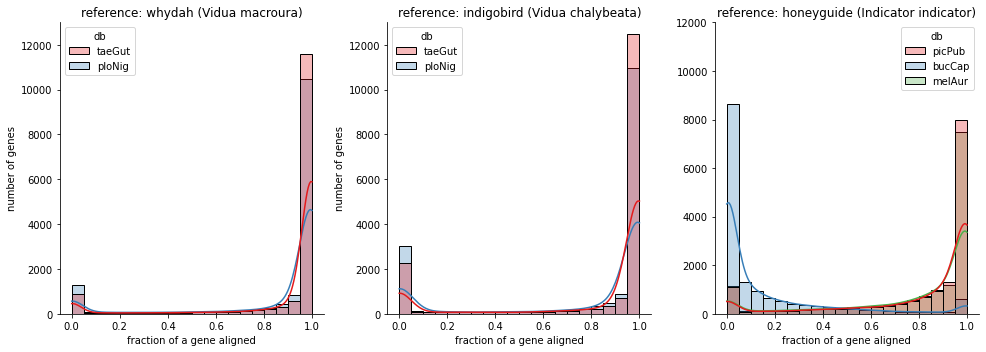

In [5]:
## Alignmnets from minimap2: what fraction of CDS do they cover?
file_name = 'Alignment_minimap_cov/bedcov_from_minimap2.tsv'
file_data = glob(dir_path + file_name)[0]
bedcov_df = pd.read_csv(file_data, sep='\t')

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.histplot(ax=axes[0], data=bedcov_df[bedcov_df['ref'] == 'vidMac'], x='fraction', hue='db',
             bins=20, kde=True, alpha=0.3, palette='Set1')
sns.histplot(ax=axes[1], data=bedcov_df[bedcov_df['ref'] == 'vidCha'], x='fraction', hue='db',
             bins=20, kde=True, alpha=0.3, palette='Set1')
sns.histplot(ax=axes[2], data=bedcov_df[bedcov_df['ref'] == 'indInd'], x='fraction', hue='db',
             bins=20, kde=True, alpha=0.3, palette='Set1')
# sns.histplot(ax=axes[2], data=bedcov_df[(bedcov_df['ref'] == 'indInd') & (bedcov_df['db'] != 'melAur')],
#              x='fraction', hue='db', bins=20, kde=True, alpha=0.3, palette='Set1')


axes[0].set_title('reference: whydah (Vidua macroura)')
axes[0].set(xlabel='fraction of a gene aligned', ylabel='number of genes')
axes[0].set(ylim=(0, 13000))
# axes[0].legend(title='', loc='upper left', labels=['zebra ficnh', 'weaver'])

axes[1].set_title('reference: indigobird (Vidua chalybeata)')
axes[1].set(xlabel='fraction of a gene aligned', ylabel='number of genes')
axes[1].set(ylim=(0, 13000))
# axes[1].legend(title='', loc='upper left', labels=['zebra ficnh', 'weaver'])

axes[2].set_title('reference: honeyguide (Indicator indicator)')
axes[2].set(xlabel='fraction of a gene aligned', ylabel='')
axes[2].set(ylim=(0, 12000))
# axes[2].legend(title='', loc='upper left', labels=['downy woodpecker', 'puffbird', 'golden-fronted woodpecker'])
# axes[2].legend(title='', loc='upper left', labels=['downy woodpecker', 'golden-fronted woodpecker'])
# axes[2].legend(title='', loc='upper left', labels=['downy woodpecker', 'puffbird'])


fig.tight_layout()  
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

# pdf_name = 'bedcov.fraction_of_genes_aligned.with_minimap2.no_woodpecker.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

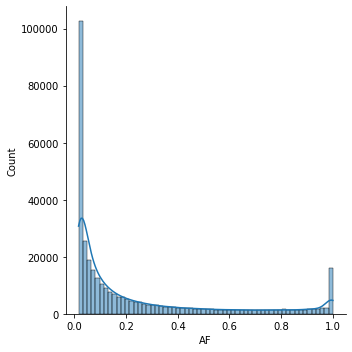

In [9]:
## minor AF for DoS < 0
db = 'indInd'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'MK_test_{}_ncbi/AF.neg_dos.passed.indInd.lst'.format(db)
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

fig, axes = plt.subplots(figsize=(5, 5))
sns.histplot(data=df, x='AF', bins=60, kde=True)

fig.tight_layout()
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)